In [1]:
from __future__ import division

In [2]:
import numpy as np
from scipy import stats
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [3]:
fb = pd.read_csv('data/pseudo_facebook.tsv', sep= '\t')
fb.shape

(99003, 15)

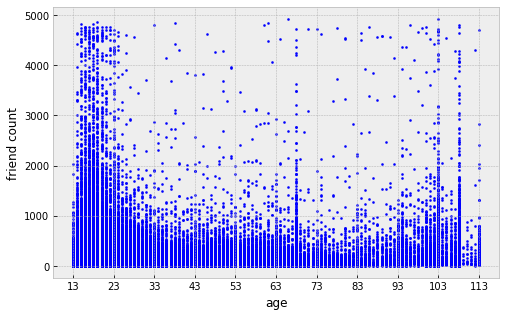

In [4]:
with plt.style.context('bmh'):
    plt.figure(figsize= (8, 5))
    plt.scatter(fb['age'], fb['friend_count'], c= 'blue', s= 4)
    plt.xlabel('age')
    plt.ylabel('friend count')
    plt.xticks(range(13, 113+1, 10))

As you see, younger users seem to have much more friends than older ones; especially those bellow 25 seem to have thousands more. Also, there is some funny spikes at age 67 and around 100. Considering the high friend count, perhaps they are fake users? Or even teenagers? 

In [5]:
"""
95% of the users are bellow the age of 90:
"""
np.percentile(fb['age'], q= [0, 25, 50, 75, 90, 95, 99, 100])

array([  13.,   20.,   28.,   50.,   67.,   90.,  108.,  113.])

As you see, 95% of the users are bellow the age of 90; so, let's limit the age to this interval: 13 to 90.  

Also, notice that the lower section of the scatterplot is __overplotted__, which makes it hart to tell how many datapoints are at each region; we'll use the __alpha__ parameter to set the transparency. By setting alpha to 1/20, it takes 20 datapoints for each point to be shown really dark in the graph. 

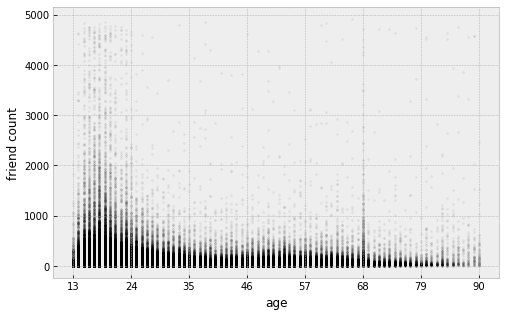

In [6]:
df = fb[fb['age'] <= 90]
with plt.style.context('bmh'):
    plt.figure(figsize= (8, 5))
    plt.scatter(df['age'], df['friend_count'], c= 'black', s= 4, alpha= 1/20)
    plt.xlabel('age')
    plt.ylabel('friend count')
    plt.xticks(range(13, 90+1, 11))

We also can get the same plot using the __seaborn__ library; I also added some noise using the `jitter` parameter in order to get a clearer picture of the relationship between friend_count and age. 

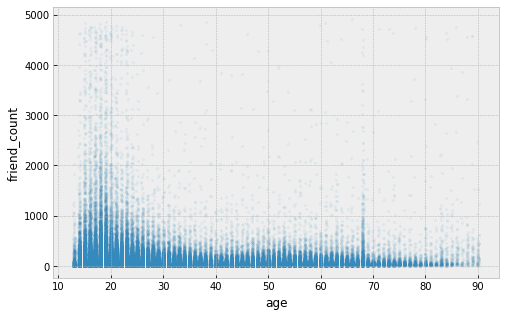

In [7]:
with plt.style.context('bmh'):
    plt.figure(figsize= (8, 5))
    sns.regplot(data= df, x= 'age', y= 'friend_count', fit_reg= False,
                scatter_kws= {'s': 4, 'alpha': 1/20},
                x_jitter= .2, y_jitter= .2,)

Now, we see that the friend_count for younger users are not exactly as high as it seemed at first glance; in fact, the bulk of them, the darker part of the plot, have lower than 1000 friends.  

By plotting the friend_count on a log-scale, we can get an even clearer picture of the relationship:

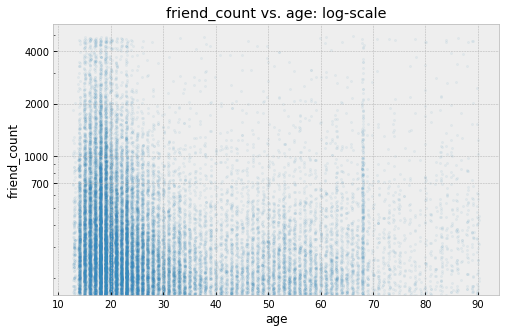

In [8]:
with plt.style.context('bmh'):
    plt.figure(figsize= (8, 5))
    ax = sns.regplot(data= df, x= 'age', y= 'friend_count', fit_reg= False,
                     scatter_kws= {'s': 4, 'alpha': 1/20},
                     x_jitter= .2, y_jitter= .2)
    ax.set_title('friend_count vs. age: log-scale')
    
    ax.set_yscale('log')
    ax.set_yticks([700, 1000, 2000, 4000])
    ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

In [9]:
"""
Let's compare the friend_count for all usrs and users bellow age of 25:
"""
p = [0, 25, 50, 75, 90, 95, 99, 100]
q1 = np.percentile(fb['friend_count'], q= p)
q2 = np.percentile(fb['friend_count'][fb['age'] < 25], q= p)

pd.DataFrame([q1, q2], columns= p, index= ['all users', 'users bellow 25']).astype('int')

,0,25,50,75,90,95,99,100
all users,0,31,82,206,440,720,1918,4923
users bellow 25,0,46,132,302,645,1036,2684,4863


## Conditional Mean:

In [10]:
q = fb[['age', 'friend_count']].groupby('age').quantile([.1, .9]).unstack()
q.head(3)

friend_count       
             0.1    0.9
age                    
13           3.0  412.7
14          12.4  569.6
15          16.0  811.6

In [11]:
fc_by_age = fb[['age', 'friend_count']].groupby('age').agg(['size', 'mean', 'median'])

fc_by_age.head(3)

friend_count                   
            size        mean median
age                                
13           484  164.750000   74.0
14          1925  251.390130  132.0
15          2618  347.692131  161.0

In [12]:
fc_by_age = fc_by_age.join(q).reset_index()
fc_by_age.head(3)

age friend_count                                
              size        mean median   0.1    0.9
0  13          484  164.750000   74.0   3.0  412.7
1  14         1925  251.390130  132.0  12.4  569.6
2  15         2618  347.692131  161.0  16.0  811.6

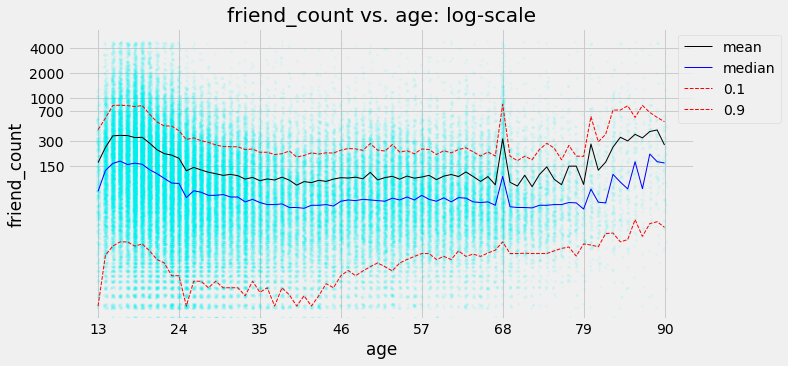

In [13]:
with plt.style.context('fivethirtyeight'):
    plt.figure(figsize= (10, 5))
    ax = sns.regplot(data= fb[fb['age'] <= 90],
                     x= 'age', y= 'friend_count',
                     fit_reg= False,
                     scatter_kws= {'color': 'cyan', 's': 4, 'alpha': 1/20},
                     x_jitter= .2, y_jitter= .2)
    
    df = fc_by_age.loc[fc_by_age['age']<=90]
    for yy, cc in zip(['mean', 'median', 0.1, 0.9], ['black', 'blue', 'red', 'red']):
        plt.plot(df['age'], df[('friend_count', yy)],
                 label= str(yy), color= cc,
                 ls= '--' if isinstance(yy, float) else '-',
                 lw= 1) # ls: linestyle; lw: linewidth 
        
    ax.set_yscale('log')
    ax.set_yticks([150, 300, 700, 1000, 2000, 4000])
    ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    
    ax.set_xticks(range(13, 90+1, 11))
    ax.set_title('friend_count vs. age: log-scale')
    plt.legend(loc= 'upper right', bbox_to_anchor= (1.15, 1))

This plot immediately reveals the increase in friend_count for very young users, and the subsequent decrease right after that. Also, we can see the dispersity of the data around the mean.     
Notice that, having more than 1000 friends is quite rare, even for younger users. In fact, average friend count for each age category is around 300, and for users between 30 to 65 it's around 150. 

## Correlation:

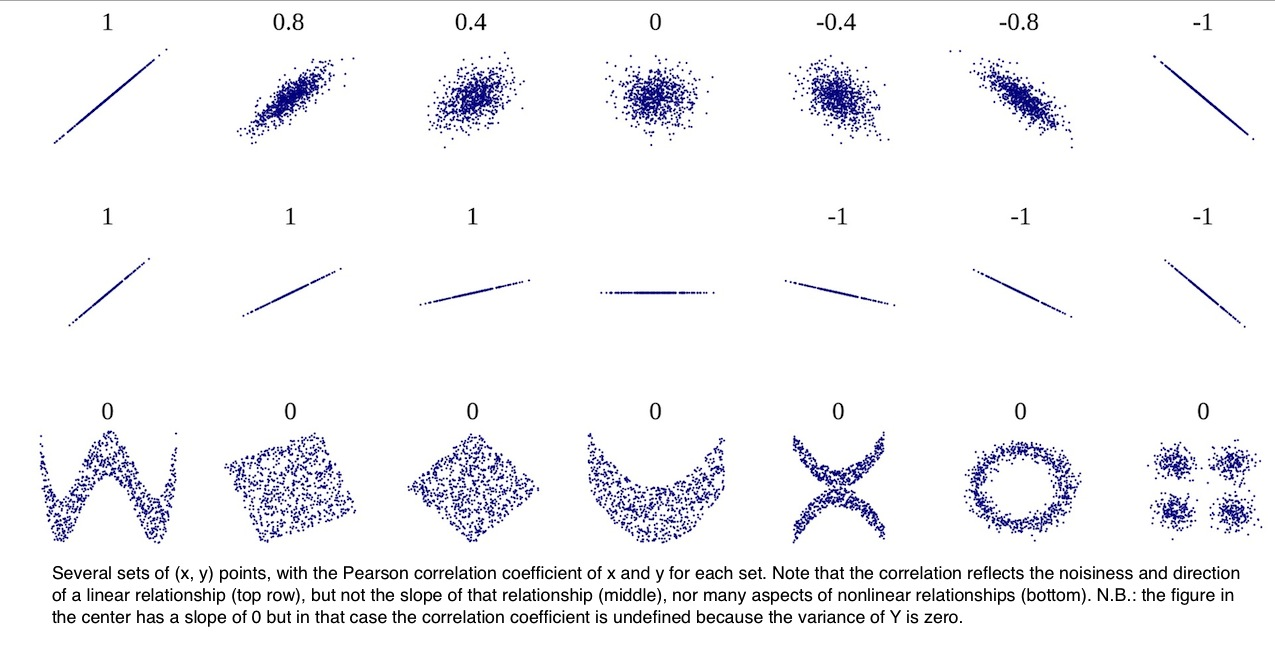

In [14]:
from IPython.display import Image

Image('data/correlation_images.jpeg')

In [15]:
"""
The correlation between friend_count and age is NOT that strong;
however, one has to keep in mind that correlation only measures
the linear relationship between the variables.
"""
stats.pearsonr(fb['friend_count'], fb['age'])[0]

-0.02740737154230409

In [16]:
"""
Now, if we limit our analysis only to users bellow age 70,
the correlation becomes stronger, but it's still not that significant.

Also, pay attention that here again the correlation is negative,
i.e., there is a reverse relationship between age and friend_count.,
as age increases, friend_count decreases."""
stats.pearsonr(fb['friend_count'][fb['age'] <= 70],
               fb['age'][fb['age'] <= 70])[0]

-0.17172448270245844

In [17]:
stats.pearsonr(fb['www_likes_received'], fb['likes_received'])[0]

0.94799018034553617

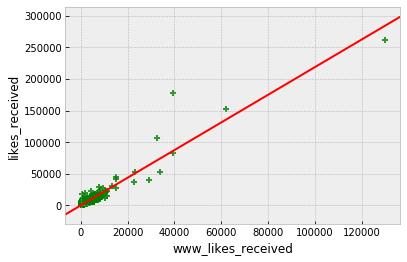

In [18]:
with plt.style.context('bmh'):
    sns.regplot('www_likes_received', 'likes_received', data= fb,
                marker= '+',
                scatter_kws= {'color': 'g'},
                line_kws= {'color': 'r', 'lw': 2},
                ci= None) # no confidence interval around the fitted line 

In [19]:
display(np.mean(fb['likes_received'] > 500) * 100,
        np.mean(fb['www_likes_received'] > 200) * 100)

5.5675080553114551

5.64023312424876

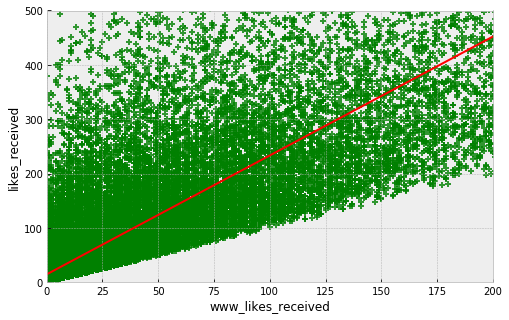

In [20]:
with plt.style.context('bmh'):
    plt.figure(figsize= (8, 5))
    sns.regplot('www_likes_received', 'likes_received', data= fb,
                marker= '+',
                scatter_kws= {'color': 'g'},
                line_kws= {'color': 'r', 'lw': 2},
                ci= None) # no confidence interval around the fitted line 
    plt.xlim(0, 200)
    plt.ylim(0, 500)

## Understanding Noise

Now, let's have a closer look at the friend_count by age:

In [21]:
"""
We also limit our analysis to users bellow age 70,
since more than 90% of the users are in this category.
"""
np.percentile(fb['age'], q= [50, 75, 90])

array([ 28.,  50.,  67.])

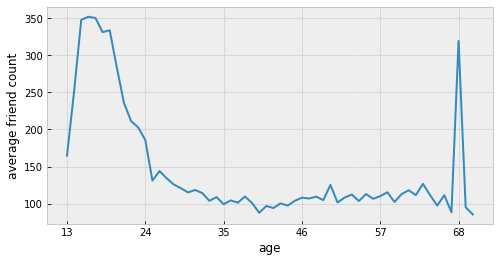

In [22]:
with plt.style.context('bmh'):
    plt.figure(figsize= (8, 4))
    df = fc_by_age[fc_by_age['age'] <= 70]
    plt.plot(df['age'], df[('friend_count', 'mean')])
    plt.ylabel('average friend count')
    plt.xlabel('age')
    plt.xticks(range(13, 70, 11))

As you see, the plot is not smooth at all, and there are lots of ups and downs; while the funny spike at age 69 may be a "real" phenomenon, others such as those between age 33 to 63 are the result of the sampling process. Especifically, let's look at the following 5 rows of the data:

In [23]:
fc_by_age.iloc[2:7, :].round(2)

age friend_count                            
              size    mean median   0.1    0.9
2  15         2618  347.69  161.0  16.0  811.6
3  16         3086  351.94  171.5  18.0  817.0
4  17         3283  350.30  156.0  18.0  808.6
5  18         5196  331.17  162.0  16.0  787.0
6  19         4391  333.69  157.0  17.0  811.0

As you see, in this sample, the mean friend count for a 16 year old is higher than that of both 15 and 17 year old. But it well could be that in another sample the situation is reversed. Hence, the average friend count line that we plotted is a true signal, that really generated the data, plus some noise which is the effect of sampling process. This is what we as data scientists have to be aware of: __the SIGNAL and the noise__.

Now, to make our point clearer, let's recalculate the `age` variable; first we make it more fine-grained, we calculate the age up to the month; for that, we assume the reference date for calculating age is December 31, 2013 and that the age variable gives age in years at the end of 2013.

In [24]:
fb['age_with_month'] = fb['age'] + (1 - fb['dob_month']/12).round(1)

In [25]:
fb['age_with_month'].describe()

count    99003.000000
mean        37.756100
std         22.584522
min         13.200000
25%         20.900000
50%         28.900000
75%         50.300000
max        113.900000
Name: age_with_month, dtype: float64

In [26]:
fc_by_age_month = fb[['age_with_month', 'friend_count']].groupby('age_with_month').agg(
                                                                    ['size', 'mean', 'median'])
fc_by_age_month = fc_by_age_month.reset_index()

In [27]:
fc_by_age_month.head()

age_with_month friend_count                   
                         size        mean median
0           13.2           20   94.450000   23.5
1           13.3           25  136.200000   44.0
2           13.4           33  164.242424   72.0
3           13.5           45  131.177778   66.0
4           13.6           54  156.814815   64.0

In [28]:
"""
Now, as you see, we have different groups in the fc_by_age_month variable,
now, each distinct age in fc_by_age, let's say 14,
has 10 corresponding values in fc_by_age_month: 14.0, 14.1, ..., 14.9.

This should make our plot more wiggly, as we see in the next plot:
"""
fc_by_age.shape, fc_by_age_month.shape

((101, 6), (996, 4))

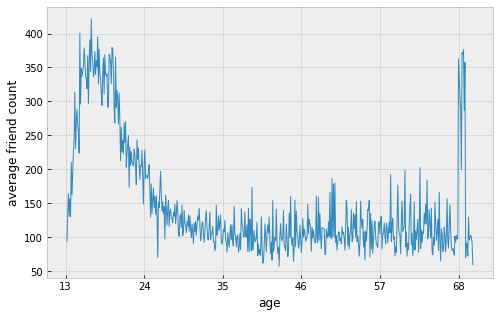

In [29]:
with plt.style.context('bmh'):
    plt.figure(figsize= (8, 5))
    df = fc_by_age_month[fc_by_age_month['age_with_month'] <= 70]
    plt.plot(df['age_with_month'], df[('friend_count', 'mean')],
             lw= 1)
    plt.ylabel('average friend count')
    plt.xlabel('age')
    plt.xticks(range(13, 70, 11))
    #plt.xlim((13, 80))

As you see, by decreasing the size of the age bins, and as a result increasing the number of bins - we have more age groups, but smaller groups- we have now less data to estimate each conditional mean, hence we have a lot more noise on this recent graph.  

On the other hand, we could go the other direction and increase the size of the bins; we could lump everyone together whose age falls under multiple of five. For example, users within 2.5 years of 40 will get lumped into one point. 

In [30]:
display(np.arange(37, 45),
        (np.arange(37, 45) / 5).round() * 5)

array([37, 38, 39, 40, 41, 42, 43, 44])

array([ 35.,  40.,  40.,  40.,  40.,  40.,  45.,  45.])

In [31]:
fb['age_2.5'] = (fb['age'] / 5).round() * 5
fb['age_2.5'].describe()

count    99003.000000
mean        37.450885
std         22.766545
min         15.000000
25%         20.000000
50%         30.000000
75%         50.000000
max        115.000000
Name: age_2.5, dtype: float64

In [32]:
fc_by_age25 = fb[['age_2.5', 'friend_count']].groupby('age_2.5').agg(['size', 'mean', 'median'])
fc_by_age25 = fc_by_age25.reset_index()
fc_by_age25.shape

(21, 4)

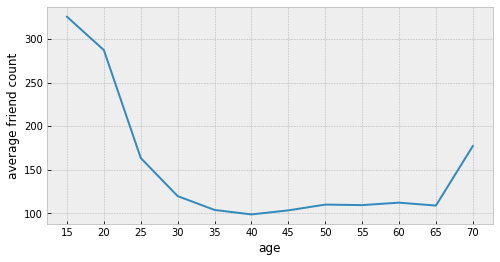

In [33]:
with plt.style.context('bmh'):
    plt.figure(figsize= (8, 4))
    df = fc_by_age25[fc_by_age25['age_2.5'] <= 70]
    plt.plot(df['age_2.5'], df[('friend_count', 'mean')])
    plt.ylabel('average friend count')
    plt.xlabel('age')
    plt.xticks(range(15, 70+1, 5))

### Which plot to choose?

Notice that in exploratory data analysis we want to get insights about data, as a result we'll often create multiple visualizations and summary statistics of the same data so we can get understand the data better. Different plots are supposed to reveal different things about the data you're looking at. 